In [2]:
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar


In [12]:
_df = pd.concat([
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_speak_test_out_domain_22sept/appliances.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_speak_test_out_domain_22sept/food.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_test_4july/adaptive_speak_test_out_domain_indoor.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_test_4july/adaptive_speak_test_out_domain_outdoor.csv', error_bad_lines=False, warn_bad_lines=True),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_test_4july/adaptive_speak_test_out_domain_vehicles.csv', error_bad_lines=False, warn_bad_lines=True)
])

# pd.to_numeric(df['target domain'], errors='coerce')

print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['interpreter domain'].unique())
_df = _df.dropna()
print('Data points:', len(_df))

id_df = _df[(_df['target domain'] == _df['listener domain'])]
ood_df = _df[(_df['target domain'] != _df['listener domain'])]

df = ood_df
df.head(2)


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_10497/2331208039.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_speak_test_out_domain_22sept/appliances.csv', error_bad_lines=False, warn_bad_lines=True),
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_10497/2331208039.py:2: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_speak_test_out_domain_22sept/appliances.csv', error_bad_lines=False, warn_bad_lines=True),
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_10497/2331208039.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  

target domain   : ['food' 'vehicles' 'outdoor' 'indoor' 'appliances']
listener domain : ['appliances' 'food']
simulator domain: ['appliances' 'food']
Data points: 6431


,Unnamed: 0,target domain,listener domain,interpreter domain,target img idx,img path #0,img path #1,img path #2,img path #3,img path #4,...,adapted_acc_s0,adapted_acc_s1,adapted_acc_s2,adapted_acc_s3,adapted_acc_s4,int_list_acc0,int_list_acc1,int_list_acc2,int_list_acc3,int_list_acc4
0,0,food,appliances,appliances,3,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1,food,appliances,appliances,1,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,/home/dizzi/Desktop/pb_speaker_adaptation/data...,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [15]:
df.keys()

Index(['Unnamed: 0', 'target domain', 'listener domain', 'interpreter domain',
       'target img idx', 'img path #0', 'img path #1', 'img path #2',
       'img path #3', 'img path #4', 'img path #5', 'golden utt',
       'original utt', 'adapted utt s0', 'adapted utt s1', 'adapted utt s2',
       'adapted utt s3', 'adapted utt s4', 'original h0', 'adapted h0 s0',
       'adapted h0 s1', 'adapted h0 s2', 'adapted h0 s3', 'adapted h0 s4',
       'loss s0', 'loss s1', 'loss s2', 'loss s3', 'loss s4', 'grad s0',
       'grad s1', 'grad s2', 'grad s3', 'grad s4', 'golden_list_out',
       'original_list_out', 'adapted_list_out_s0', 'adapted_list_out_s1',
       'adapted_list_out_s2', 'adapted_list_out_s3', 'adapted_list_out_s4',
       'original_int_out', 'adapted_int_out_s0', 'adapted_int_out_s1',
       'adapted_int_out_s2', 'adapted_int_out_s3', 'golden_acc',
       'original_acc', 'int_acc_s0', 'int_acc_s1', 'int_acc_s2', 'int_acc_s3',
       'int_acc_s4', 'adapted_acc_s0', 'adapted_ac

In [8]:
S = 5

In [13]:
# df = df[df['target domain'] != df['listener domain']]
df = df[df['listener domain'] != 'all']
df = df[df['interpreter domain'] != 'all']
print('OOD data points:', len(df))

OOD data points: 5932


In [19]:
print('{:.2f}'.format(100 * df['golden_acc'].mean()))
print('{:.2f}'.format(100 * df['original_acc'].mean()))
for s in range(S):
    print('{:.2f}'.format(100 * df[f'adapted_acc_s{s}'].mean()))

14.87
14.04
1.85
1.47
1.35
1.37
2.24


In [20]:
refs = df['golden utt'].tolist()
hyps = {
    "h0": df['original utt'].tolist(),
    "h0' 0": df['adapted utt s0'].tolist(),
    "h0' 1": df['adapted utt s1'].tolist(),
    "h0' 2": df['adapted utt s2'].tolist(),
    "h0' 3": df['adapted utt s3'].tolist(),
    "h0' 4": df['adapted utt s4'].tolist(),
#     "h0' 5": df['adapted utt s5'].tolist(),
#     "h0' 6": df['adapted utt s6'].tolist(),
#     "h0' 7": df['adapted utt s7'].tolist(),
#     "h0' 8": df['adapted utt s8'].tolist(),
#     "h0' 9": df['adapted utt s9'].tolist(),
}

In [21]:
vocabs = defaultdict(lambda: Counter())

for ref in refs:
    for tok in ref.strip().split():
        vocabs['ref'][tok] += 1

for hyp_type in hyps:
    for hyp in hyps[hyp_type]:
        for tok in hyp.strip().split():
            vocabs[hyp_type][tok] += 1


In [22]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood


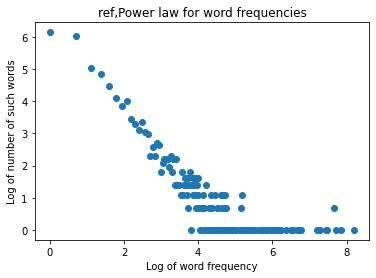

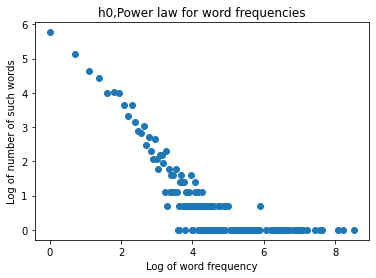

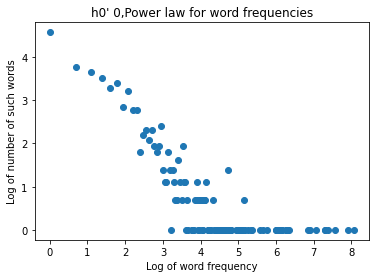

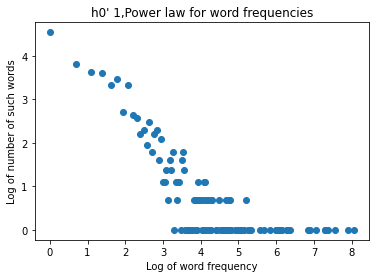

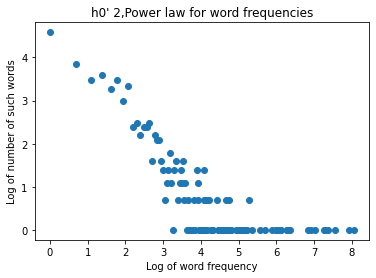

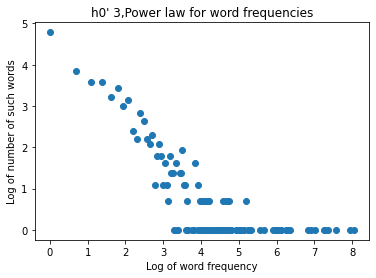

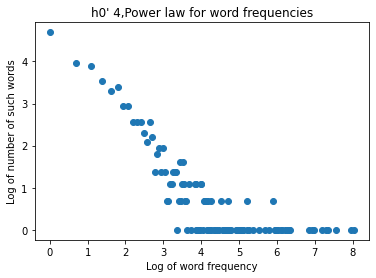

In [23]:
for typ in ['ref'] + list(hyps.keys()):

    counter_of_words = vocabs[typ]
    counter_of_counts = Counter(counter_of_words.values())
    word_counts = np.array(list(counter_of_counts.keys()))
    freq_of_word_counts = np.array(list(counter_of_counts.values()))

    # s_best = minimize_scalar(neg_zipf_likelihood)
    # print()

    plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
    plt.xlabel('Log of word frequency')
    plt.ylabel('Log of number of such words')
    plt.title(f'{typ},Power law for word frequencies') # (s = {:.2f})'.format(s_best.x))
    plt.show();

for typ in ['ref'] + list(hyps.keys()):
    vocab_df = pd.DataFrame.from_records(vocabs[typ].most_common(), columns=['word','frequency'])
    ax = vocab_df.plot.bar(x='word', y='frequency', title=typ)
    plt.show()

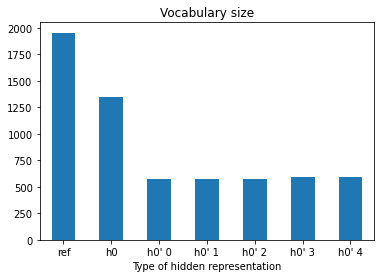

In [26]:
types = ['ref'] + list(hyps.keys())

size_df = pd.DataFrame({
    'Type of hidden representation': types,
    'Vocab size': [len(vocabs[x]) for x in types]
})

ax = size_df.plot.bar(x='Type of hidden representation', y='Vocab size', rot=0, title='Vocabulary size')
plt.legend().remove()

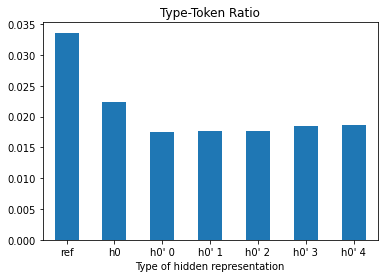

In [29]:
ttr = []
for typ in types:
    ttr.append(len(vocabs[typ]) / sum(vocabs[typ].values()) )

ttr_df = pd.DataFrame({
    'Type of hidden representation': types,
    'ttr': ttr
})

ax = ttr_df.plot.bar(x='Type of hidden representation', y='ttr', rot=0, title='Type-Token Ratio')
plt.legend().remove()